In [1]:
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer,accuracy_score, average_precision_score, cohen_kappa_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from  xgboost import  XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from optuna.samplers import TPESampler

****

### Introduction

In this notebook, we will analyze a synthetic human resources dataset created by IBM to understand various data science questions. The dataset includes information about employees such as their age, education, job role, income, and job satisfaction, as well as whether they have left the company or not. We will explore the relationships between different variables and try to identify the factors that contribute to employee attrition.

Our analysis will include data analysis, statistical tests, basic machine learning, advanced machine learning algorithms, and hyperparameter optimization using Optuna. The goal is to build a predictive model that can accurately identify employees who are likely to leave the company, as well as to gain insights into the factors that affect employee satisfaction and retention.

Let's get started with some data exploration and analysis.
### TASK 1 => Data Analysis
### TASK 2 => Machine Learning

# **TASK 1 => Data Analysis**

In [2]:
df = pd.read_csv('/kaggle/input/employee-attrition-and-factors/HR_Analytics.csv.csv')
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Our dataset contains 1470 observations and 35 variables consisting of both categorical and numerical values. Sure, let's try to answer some questions that will help your business better understand its employees, optimize workforce planning, and improve the hiring process. Let's get started!

****

**1. Which departments have the highest turnover rates?**

In [3]:
df['Attrition'] = np.where(df['Attrition'] == 'Yes', 1, 0)
df_dept = df.groupby('Department')['Attrition'].mean().reset_index()
df_dept

,Department,Attrition
0,Human Resources,0.190476
1,Research & Development,0.138398
2,Sales,0.206278


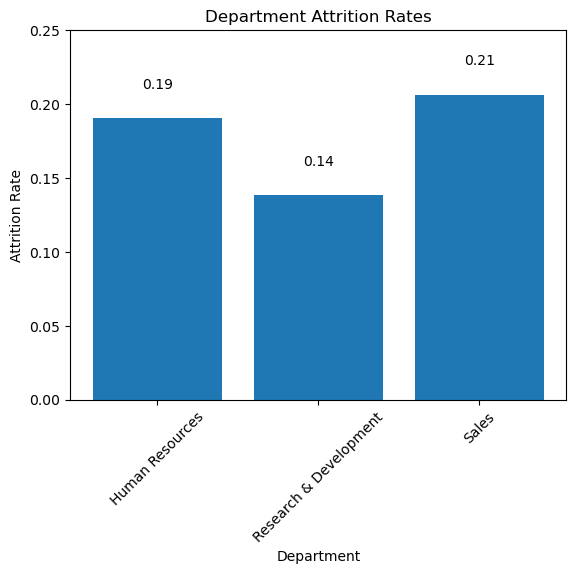

In [4]:

plt.bar(df_dept['Department'], df_dept['Attrition'])
plt.title('Department Attrition Rates')
plt.xlabel('Department')
plt.ylabel('Attrition Rate')
plt.ylim((0, 0.25))
plt.xticks(rotation=45)
for i, rate in enumerate(df_dept['Attrition']):
    plt.text(i, rate+0.02, f'{rate:.2f}', ha='center')

plt.show()

It appears that the highest turnover has occurred in the Sales department. The reasons for this should be investigated to reduce turnover.

****

**2. Which departments do employees with high salaries usually work in?**

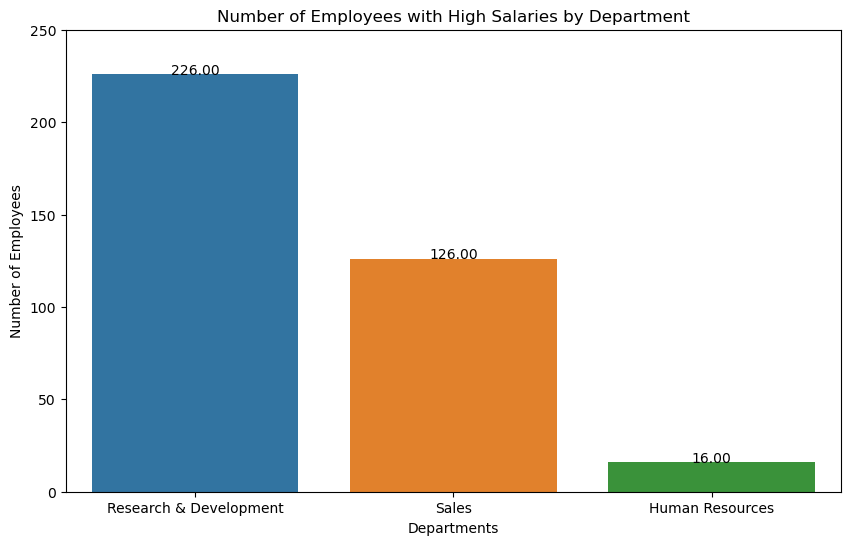

In [5]:
high_income = df[df['MonthlyIncome'] > df['MonthlyIncome'].quantile(0.75)]


department_counts = high_income['Department'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=department_counts.index, y=department_counts.values)
plt.title('Number of Employees with High Salaries by Department')
plt.xlabel('Departments')
plt.ylabel('Number of Employees')
plt.ylim((0, 250))
for i, rate in enumerate(department_counts):
    plt.text(i, rate+0.02, f'{rate:.2f}', ha='center')
plt.show()

As can be seen from the graph, employees in the Research & Development department are allocated higher salaries.

****

**3. Which education level do employees with higher salaries have?**

In [6]:
ed_level = df.groupby('Education')['MonthlyIncome'].mean().reset_index()
ed_level

,Education,MonthlyIncome
0,1,5640.570588
1,2,6226.645390
2,3,6517.263986
3,4,6832.402010
4,5,8277.645833


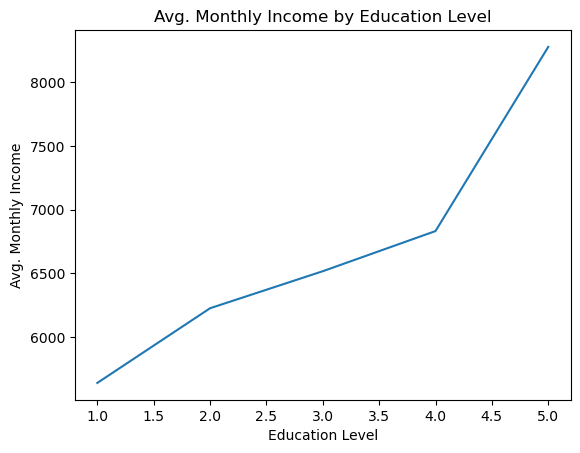

In [7]:

plt.plot(ed_level['Education'], ed_level['MonthlyIncome'])
plt.xlabel('Education Level')
plt.ylabel('Avg. Monthly Income')
plt.title('Avg. Monthly Income by Education Level')
plt.show()

As the education level increases, we can say that the average monthly income also increases. Therefore, employees with higher education levels usually receive higher salaries

****

**4. Does gender have an effect on turnover rates?**

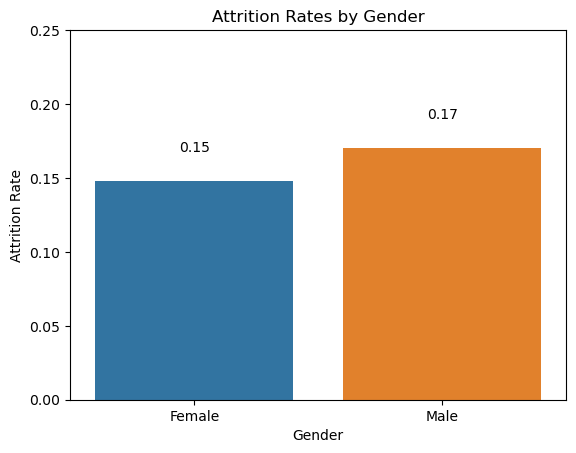

In [8]:
# Gender and Attrition columns are grouped
gender_att = df.groupby(['Gender', 'Attrition'])['Attrition'].count().unstack()

# Attrition rates are calculated for each group
gender_att['Attrition Rate'] = gender_att[1] / (gender_att[1] + gender_att[0])

# Bar plot is created
sns.barplot(x=gender_att.index, y=gender_att['Attrition Rate'])
plt.title('Attrition Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Attrition Rate')
plt.ylim((0, 0.25))
for i, rate in enumerate(gender_att['Attrition Rate']):
    plt.text(i, rate+0.02, f'{rate:.2f}', ha='center')
plt.show()

When we look at the leaving rates, it is seen that the probability of leaving the women employees is 0.15, and the probability of leaving the men is 0.17. These results suggest that it is not possible to say that gender has an effect on leaving the job.

****

**5. Is there a relationship between job satisfaction and turnover rates?**

In [9]:
from scipy.stats import chi2_contingency, ttest_ind

It is not safe to answer this question solely based on a graph. Therefore, in order to answer it, I will use statistical tests.

In [10]:
sa_att = df.groupby(['JobSatisfaction', 'Attrition'])['Attrition'].count().unstack()

# Attrition rates are calculated for each group
sa_att['Attrition Rate'] = sa_att[1] / (sa_att[1] + sa_att[0])
sa_att

Attrition,0,1,Attrition Rate
JobSatisfaction,,,
1,223,66,0.228374
2,234,46,0.164286
3,369,73,0.165158
4,407,52,0.113290


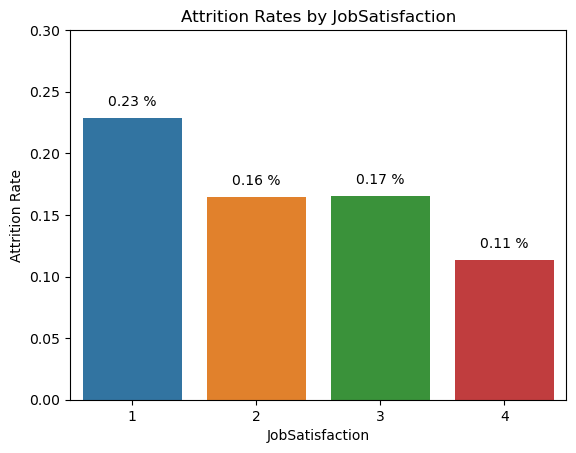

In [11]:
# Bar plot is created
sns.barplot(x=sa_att.index, y=sa_att['Attrition Rate'])
plt.title('Attrition Rates by JobSatisfaction')
plt.xlabel('JobSatisfaction')
plt.ylabel('Attrition Rate')
plt.ylim((0, 0.3))
for i, rate in enumerate(sa_att['Attrition Rate']):
    plt.text(i, rate+0.01, f'{rate:.2f} %', ha='center')
plt.show()

****4.1 Correlation Test****

In [12]:
correlation = df["JobSatisfaction"].corr(df["Attrition"])
print("Correlation: ", correlation)

Correlation:  -0.10348112606902116


We observe a correlation of 0.1. However, we should remember that correlation measures linear relationships and we cannot make a conclusion based solely on this result. Chi-square test can be used to investigate a binary relationship between categorical variables. Let me apply this test and see the results.

****4.2 Chi-square Test****

In [13]:
contingency_table = pd.crosstab(df["Gender"], df["Attrition"])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistics: ", chi2)
print("p-value: ", p_value)

Chi-square statistics:  1.1169671241970975
p-value:  0.29057244902890855


The p-value is a statistical measure used in hypothesis testing. The p-value obtained from the chi-square test indicates the probability of the tested hypothesis being true. Typically, an acceptable p-value level is determined, and if the obtained p-value is lower than that level, the hypothesis is rejected. Therefore, a p-value of 0.29 indicates that there is not enough evidence to reject the tested hypothesis, as it is above an acceptable level. In this case, we can conclude that there is no significant relationship between the variables.

****4.3 T-Test****

T-test is a statistical test used to test the significance of the difference between two groups.We will convert the JobSatisfaction column, which consists of 4 groups, into a binary structure in which JobSatisfaction levels below 3 are classified as negative and levels 3 and above are classified as positive. Then, we will perform a test.

In [14]:
satisfied = df[df["JobSatisfaction"] >= 3]
not_satisfied = df[df["JobSatisfaction"] < 3]

t_statistic, p_value = ttest_ind(satisfied["Attrition"], not_satisfied["Attrition"])

print("T-test statistics: ", t_statistic)
print("p-value: ", p_value)

T-test statistics:  -2.957368420952157
p-value:  0.003152374537239955


The obtained p-value of 0.03 represents the probability of the tested hypothesis being true. Usually, an acceptable level of p-value is determined and if the obtained p-value is lower than this level, the hypothesis is rejected. Therefore, a p-value of 0.03 shows that there is sufficient evidence to reject the tested hypothesis, as it is below an acceptable level. In this case, we can conclude that the difference between the two groups is significant.This result suggests that if the JobSatisfaction column is transformed into binary data, it may have a significant effect on job retention. This information can also be used when building a machine learning model.

# **TASK 2 => Machine Learning**

Before creating a machine learning model, it is crucial to have a deep understanding of the data. Otherwise, your model may produce poor results, and it can be challenging to interpret those results.I have 35 variables in my data set. After categorizing these variables as categorical and numerical, I will continue the analysis.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

We observed that when we set the JobSatisfaction value to a binary state in the Data Analysis section, it had an effect on our target variable. So I'm going to convert this variable to binary data by creating a new column.

In [16]:
df['Satisfied'] = np.where(df["JobSatisfaction"] >= 3, 1, 0)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Satisfied
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,1
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,1
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,1
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0


In [17]:
cat_features = df.select_dtypes('object').copy()
num_features = df.select_dtypes(['float64', 'int64']).copy()
cat_features.head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


In [18]:
num_features.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Satisfied
0,41,1,1102,1,2,1,1,2,94,3,...,80,0,8,0,1,6,4,0,5,1
1,49,0,279,8,1,1,2,3,61,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1,1373,2,2,1,4,4,92,2,...,80,0,7,3,3,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,56,3,...,80,0,8,3,3,8,7,3,0,1
4,27,0,591,2,1,1,7,1,40,3,...,80,1,6,3,3,2,2,2,2,0


I will use a boxplot graph to examine the structure of numeric data.

In [19]:
def plot_numeric_variable_boxplots(dataframe):
    numerical_vars = dataframe.select_dtypes(include=['float64', 'int64']).columns
    num_vars = len(numerical_vars)
    rows = (num_vars // 4) + (num_vars % 4)
    
    fig, axs = plt.subplots(rows, 4, figsize=(20, 6*rows))
    axs = axs.flatten()
    
    for i, var in enumerate(numerical_vars):
        sns.boxplot(data=dataframe, x=var, ax=axs[i])
        axs[i].set_title(f"Boxplot of {var}")
    
    for i in range(num_vars, 4*rows):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

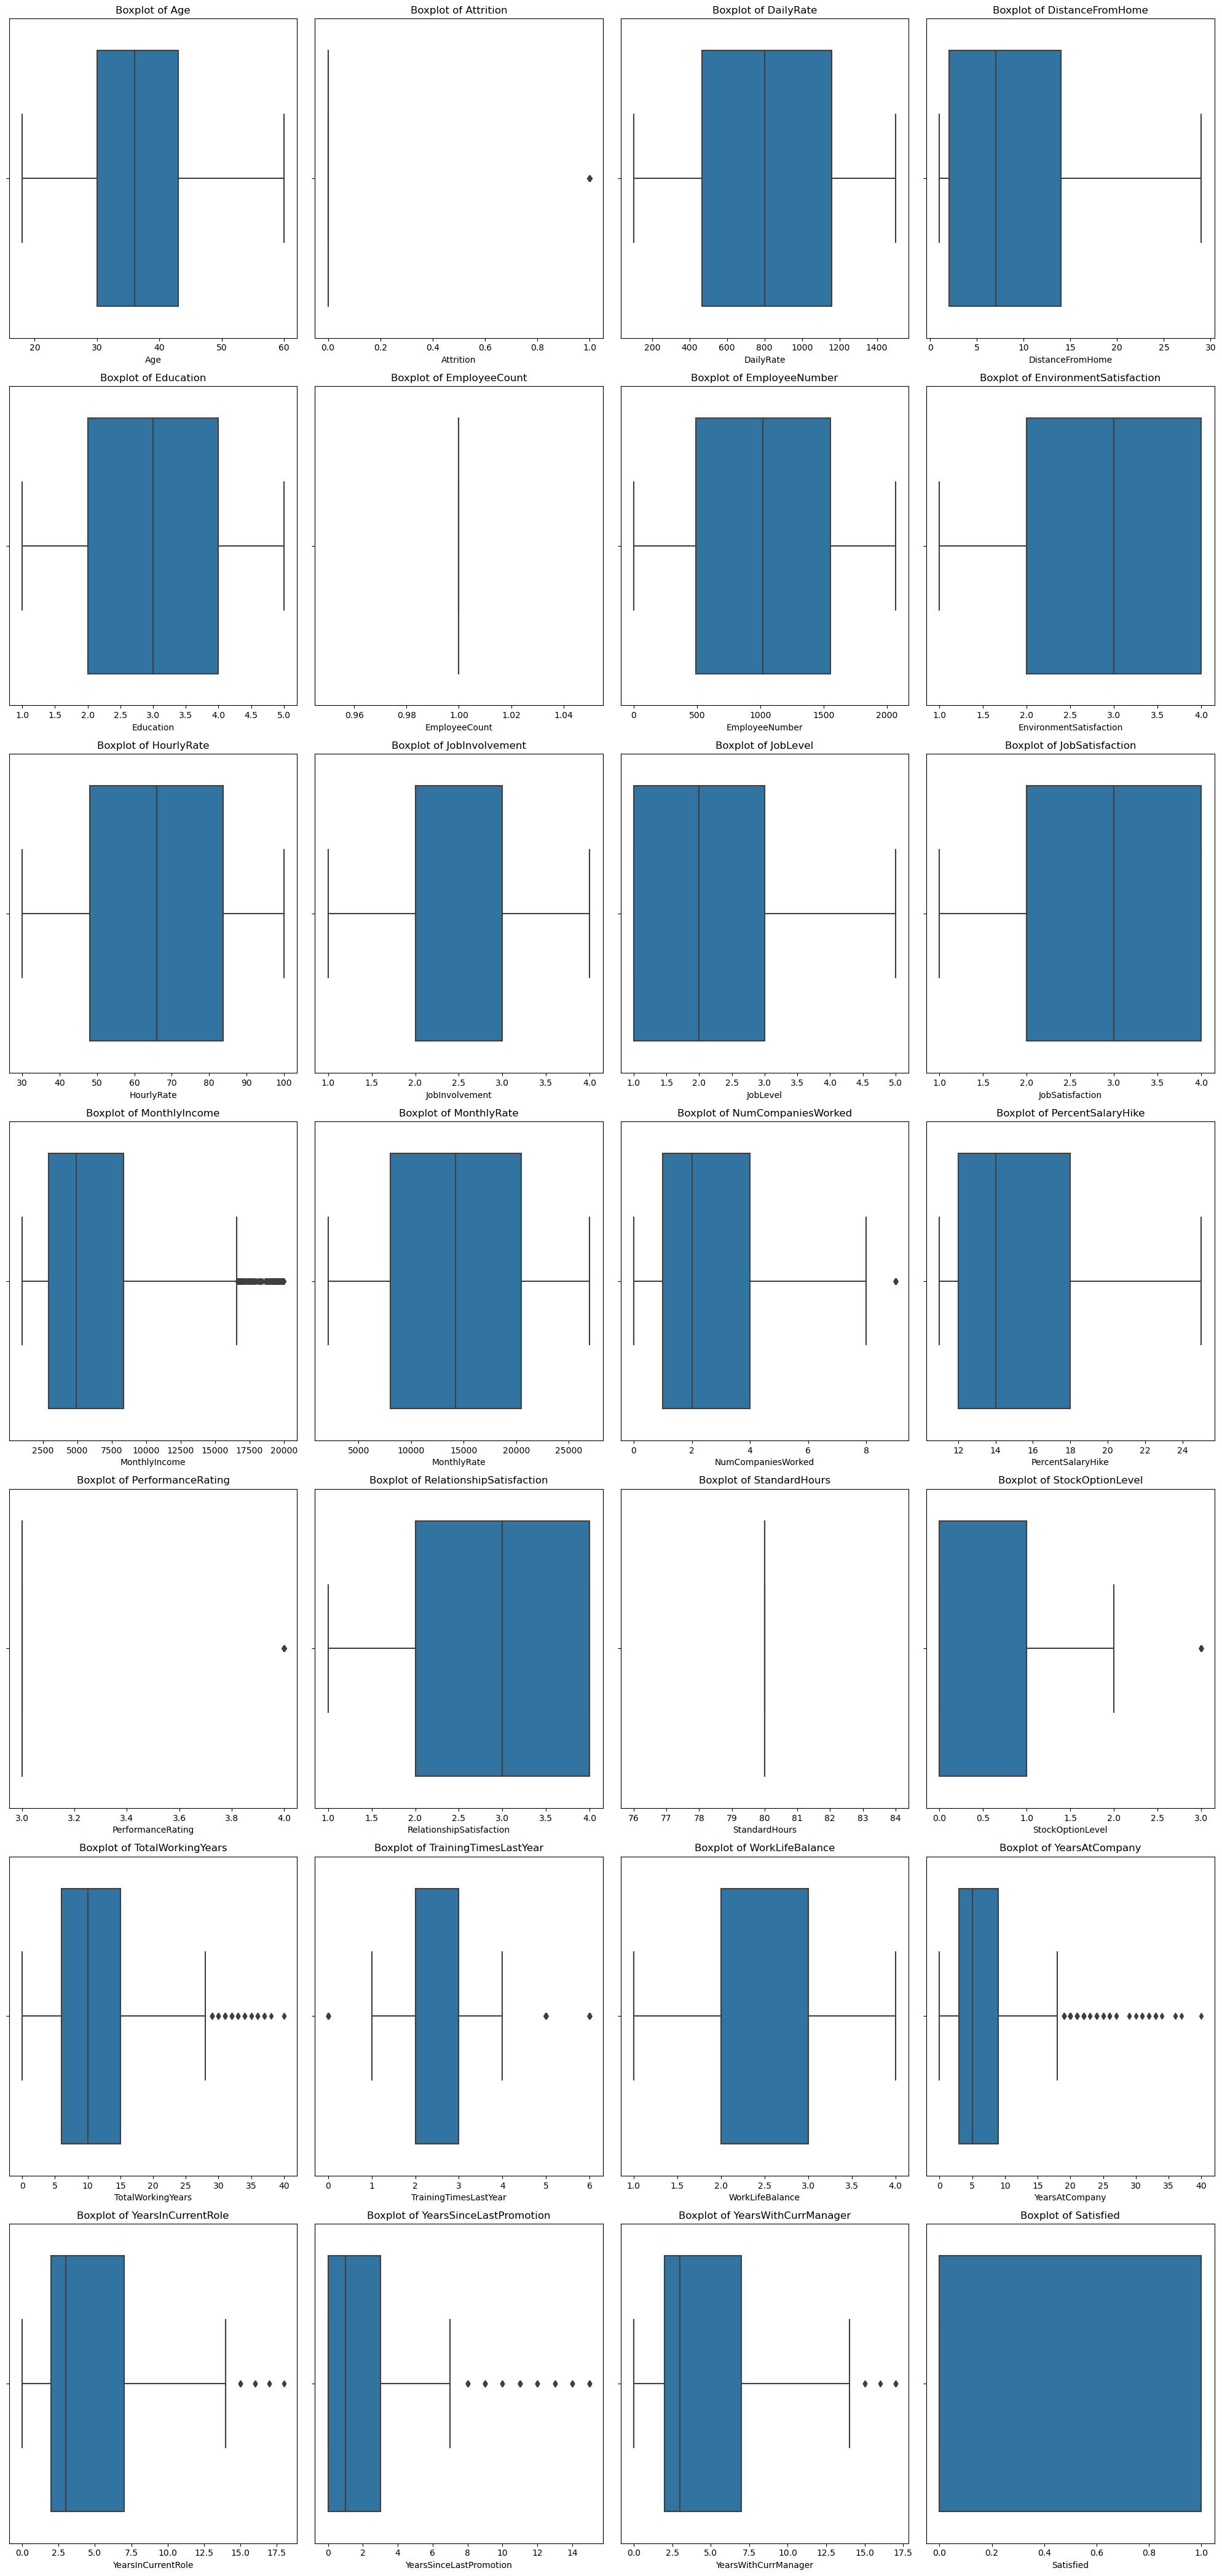

In [20]:
plot_numeric_variable_boxplots(num_features)

Is there anything that caught your attention in the graphs? If your answer is "outliers", you are on the right track. However, if you look more carefully, you will notice that the box plot for 'StandardHours' and 'EmployeeCount' has only one point. This shows us that these variables consist of only one value. There is no point in including these columns in the model. EmployeeNumber is also a column that should not be included in the model because EmployeeNumber represents a unique value for each employee and is created to establish relationships with other tables in relational databases. Therefore, this value has no relation with the measurements and cannot be included in the model. Since Attrition, Satisfied, Performance Rating columns are categorical columns, I will add these columns to the cat_features data.

In [21]:
num_features.drop(['EmployeeNumber', 'Attrition', 'PerformanceRating', 'Satisfied',
                   'EmployeeCount', 'StandardHours'], axis = 1, inplace = True)

Let's now write a correlation heatmap function to visualize the relationships among our data.

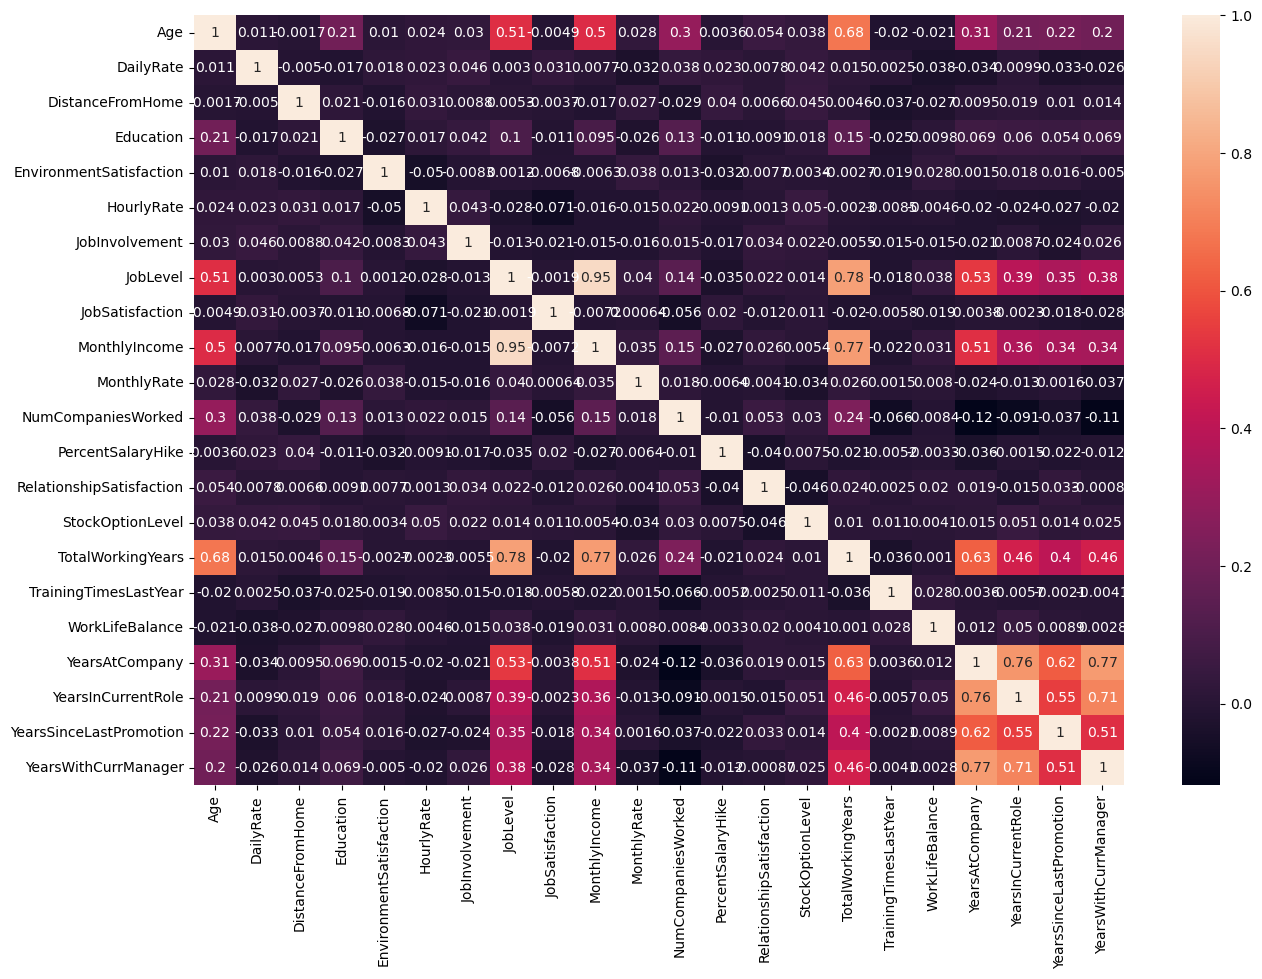

In [22]:
def plot_correlation_map(dataframe):
    numerical_vars = dataframe.select_dtypes(include=['float64', 'int64']).columns
    corr = dataframe[numerical_vars].corr()
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True)
    plt.show()
    
plot_correlation_map(num_features)

According to the graph, there is a high correlation between some variables. I will not do anything about it for now. If the result of my model is not good for me, I will return to this part again. Now I create a function to see the count graph of categorical data

In [23]:
def plot_categorical_variable_countplot(dataframe):
    cat_vars = dataframe.columns
    num_vars = len(cat_vars)
    rows = (num_vars // 3) + (num_vars % 3)
    
    fig, axs = plt.subplots(rows, 3, figsize=(20, 6*rows))
    axs = axs.flatten()
    
    for i, var in enumerate(cat_vars):
        sns.countplot(data=dataframe, x=var, ax=axs[i])
        axs[i].set_title(f"Countplot of {var}")
    
    for i in range(num_vars, 3*rows):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

In [24]:
cat_features[['Attrition', 'PerformanceRating', 'Satisfied']] = df[['Attrition', 'PerformanceRating', 'Satisfied']].copy()

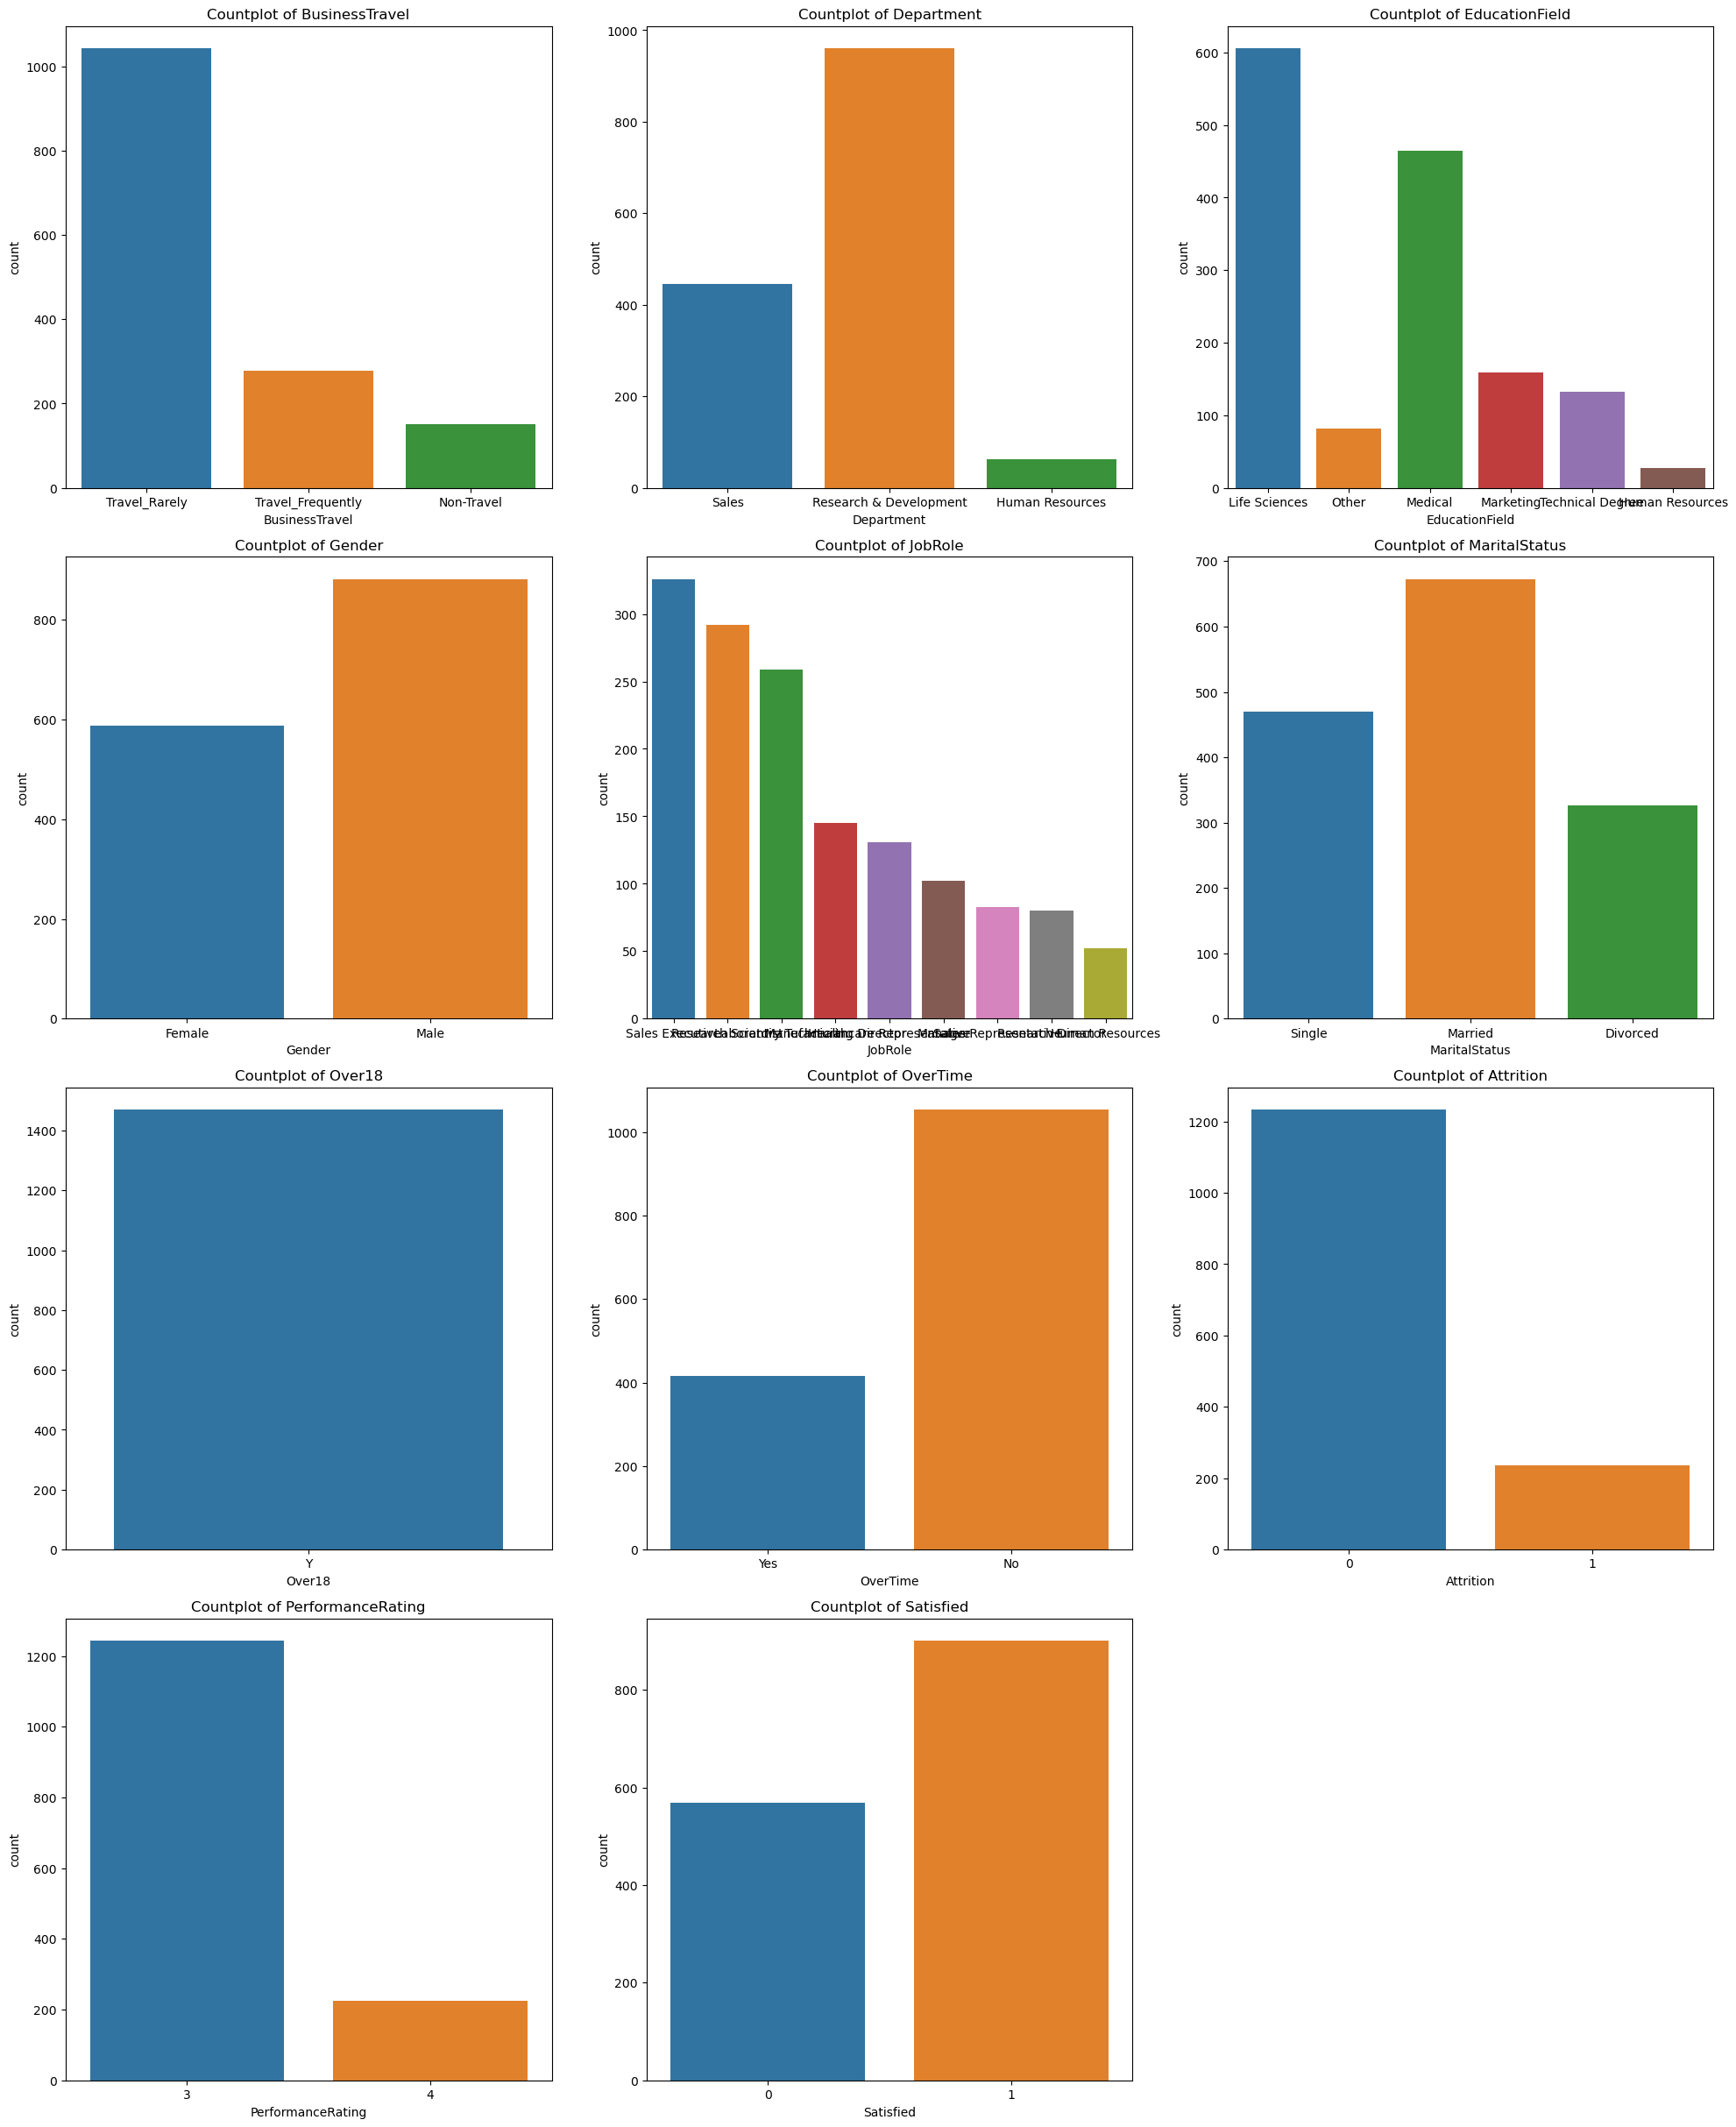

In [25]:
plot_categorical_variable_countplot(cat_features)

The 'Over 18' column immediately catches our attention. It seems that there are no employees younger than 18 in this dataset. For this reason, I will not include this column in the model. If you look closely, you can see that the distribution in the Attrition column, which is our target variable, is imbalanced. This means that we cannot choose accuracy as our model evaluation metric.

In [26]:
cat_features.drop('Over18', axis = 1, inplace = True)

The above graph shows that there are outliers in some of our variables. Many statistical tests and machine learning algorithms are sensitive to outliers. Therefore, outlier observations need to be identified, reviewed, and potentially addressed. If your data is normally distributed, you can use z-score to change outlier values. However, z-score can sometimes be misleading for data that is not normally distributed. It is important to note that not every outlier is necessarily an error. In some cases, outliers are indicative of high variance in the dataset. I created a function below. The function catches the outliers and replaces them with the value that stops at the outlier boundary in the data. The function takes 3 values. The data you want to delete outliers, the method you will use to delete, and a "multiplier" value depending on the method. If you choose the outlier method as std, set "multiplier" to 3

In [27]:
def replace_outliers_with_upper(dataframe, method='iqr', multiplier=1.5):
    numerical_vars = dataframe.select_dtypes(include=['float64', 'int64']).columns
    for var in numerical_vars:
        if method == 'iqr':
            Q1 = dataframe[var].quantile(0.25)
            Q3 = dataframe[var].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            dataframe[var] = np.where(dataframe[var] >= upper_bound, upper_bound, dataframe[var])
        elif method == 'std':
            mean = dataframe[var].mean()
            std = dataframe[var].std()
            lower_bound = mean - multiplier * std
            upper_bound = mean + multiplier * std
            dataframe[var] = np.where(dataframe[var] >= upper_bound, dataframe[dataframe[var] <= upper_bound][var].max(), dataframe[var])
        else:
            raise ValueError("Invalid method. Choose either 'iqr' or 'std'.")
    return dataframe

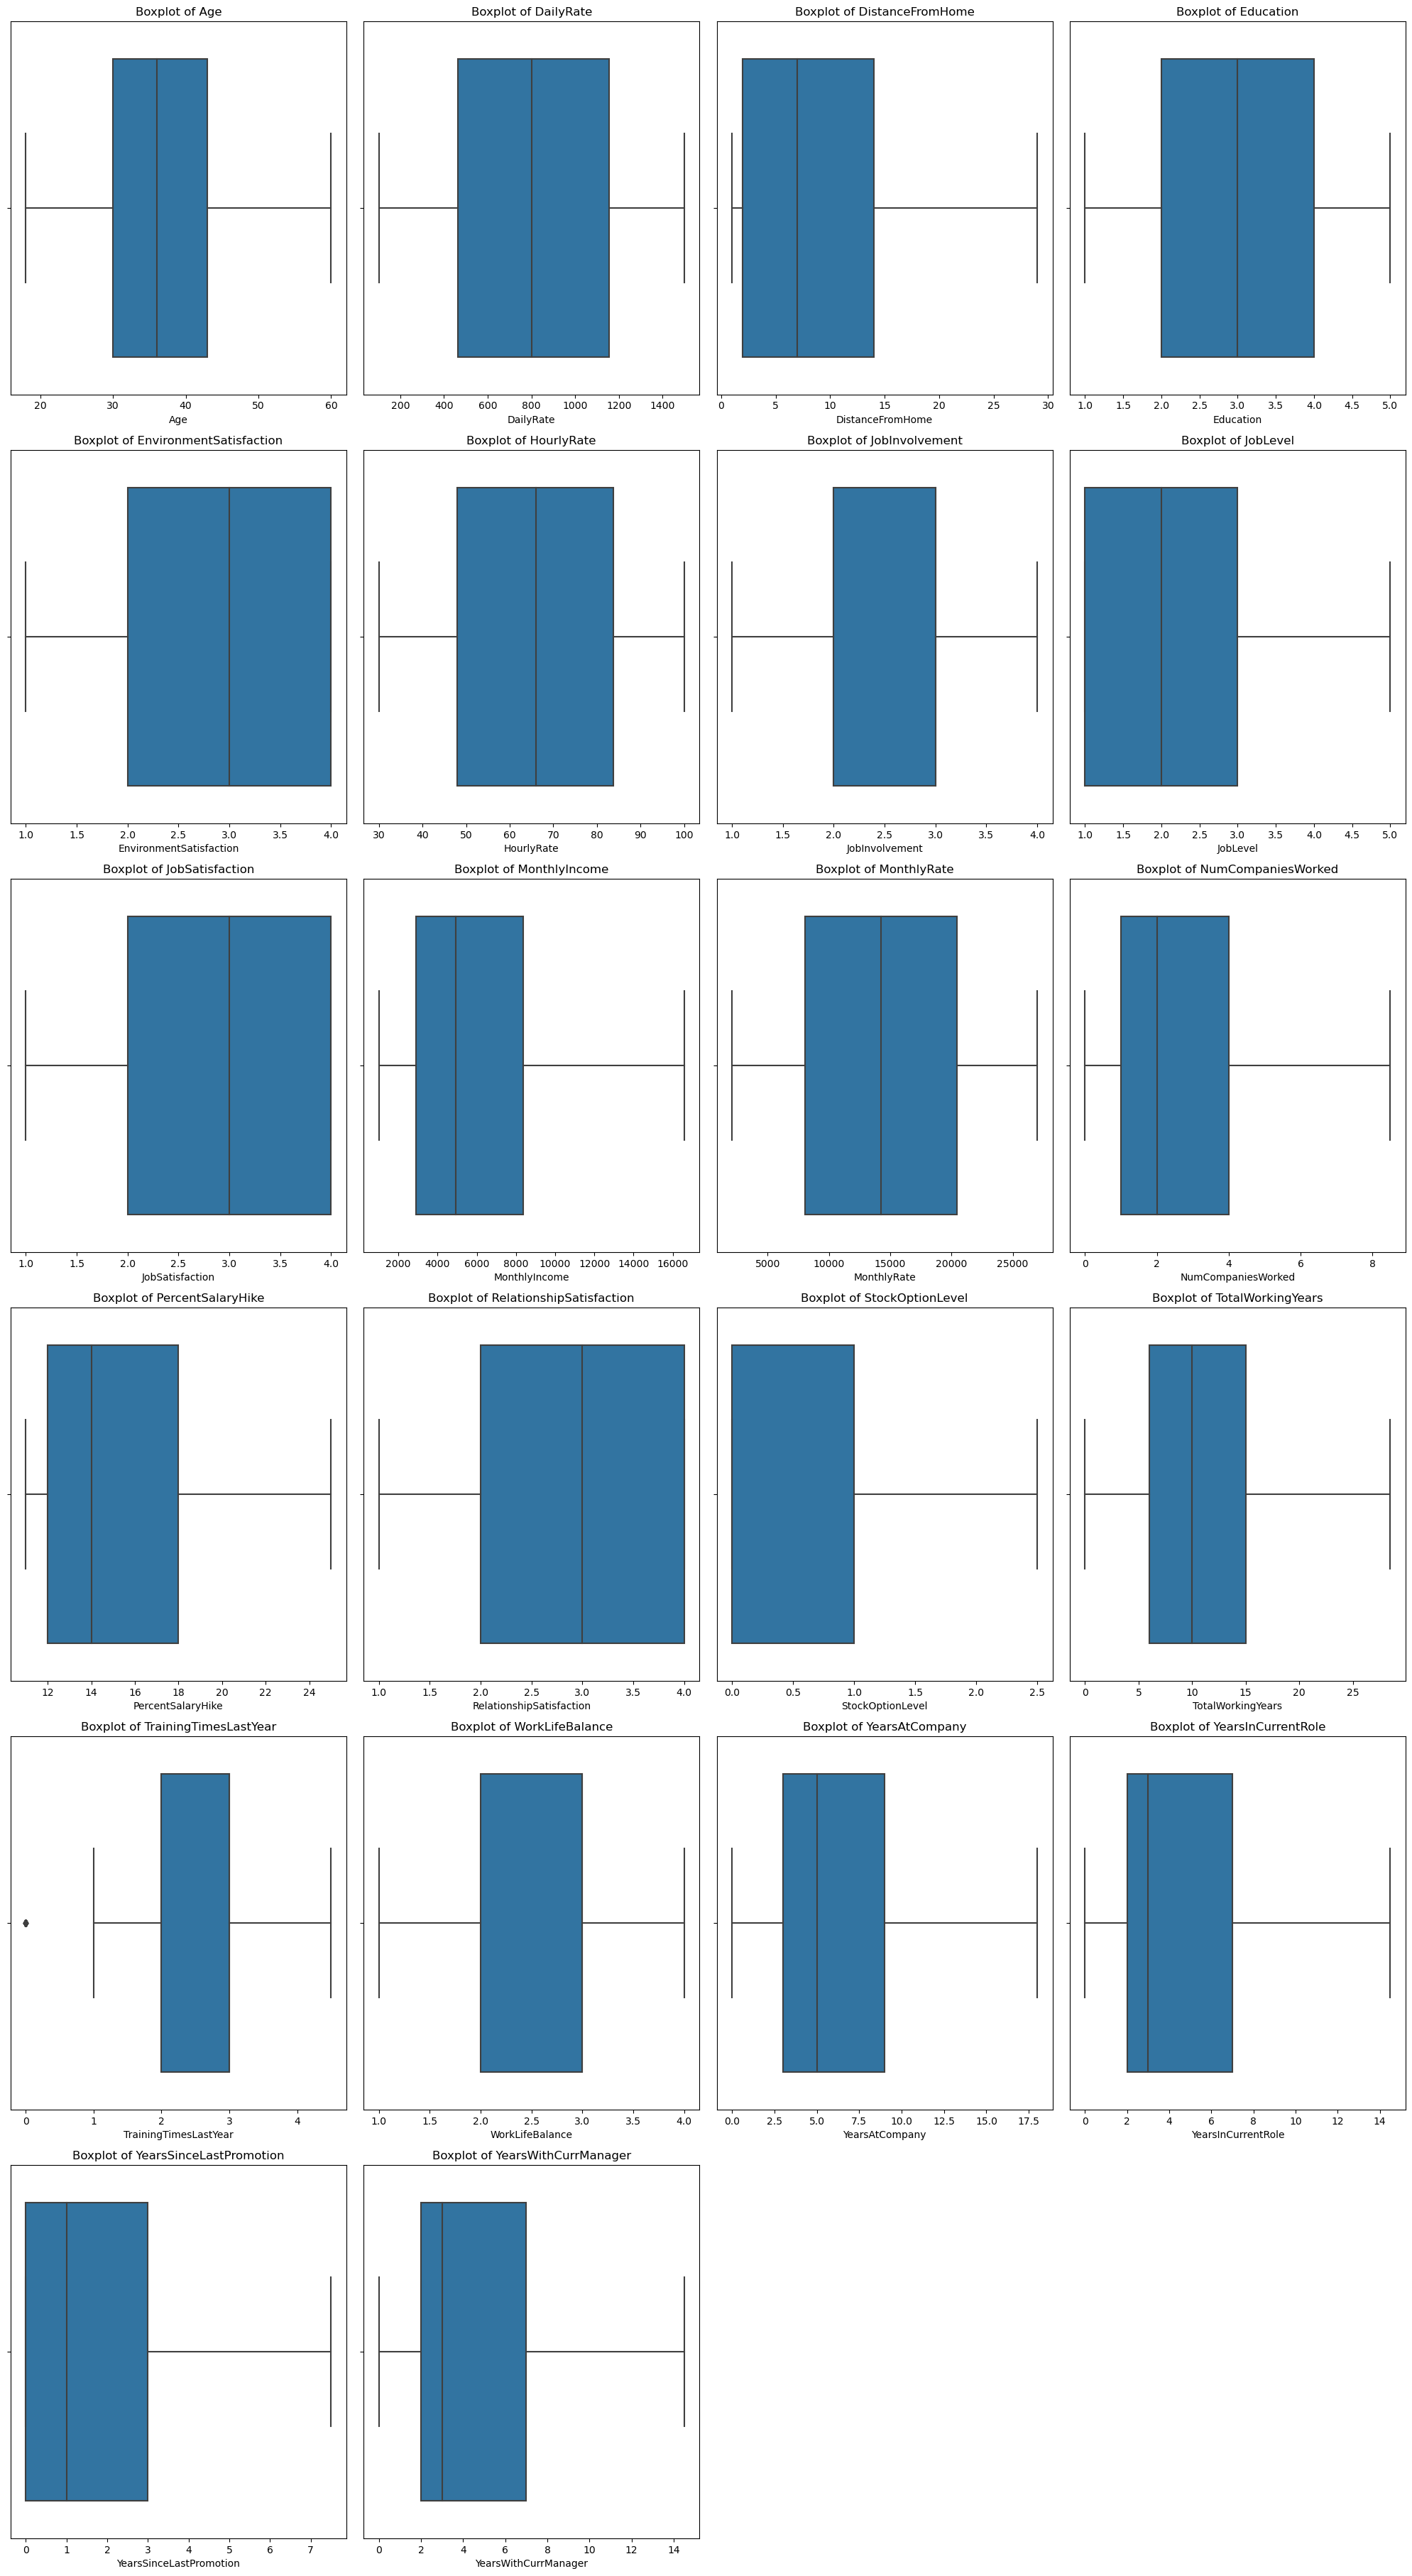

In [28]:
num_features = replace_outliers_with_upper(num_features)
plot_numeric_variable_boxplots(num_features)

In [29]:
num_columns = list(num_features.columns)
cat_columns = list(cat_features.columns)

In [30]:
df[num_columns] = num_features
df[cat_columns] = cat_features
df.drop(['Over18', 'EmployeeNumber', 'EmployeeCount', 'StandardHours'], axis = 1, inplace = True)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Satisfied
0,41.0,1,Travel_Rarely,1102.0,Sales,1.0,2.0,Life Sciences,2.0,Female,...,1.0,0.0,8.0,0.0,1.0,6.0,4.0,0.0,5.0,1
1,49.0,0,Travel_Frequently,279.0,Research & Development,8.0,1.0,Life Sciences,3.0,Male,...,4.0,1.0,10.0,3.0,3.0,10.0,7.0,1.0,7.0,0
2,37.0,1,Travel_Rarely,1373.0,Research & Development,2.0,2.0,Other,4.0,Male,...,2.0,0.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,1
3,33.0,0,Travel_Frequently,1392.0,Research & Development,3.0,4.0,Life Sciences,4.0,Female,...,3.0,0.0,8.0,3.0,3.0,8.0,7.0,3.0,0.0,1
4,27.0,0,Travel_Rarely,591.0,Research & Development,2.0,1.0,Medical,1.0,Male,...,4.0,1.0,6.0,3.0,3.0,2.0,2.0,2.0,2.0,0


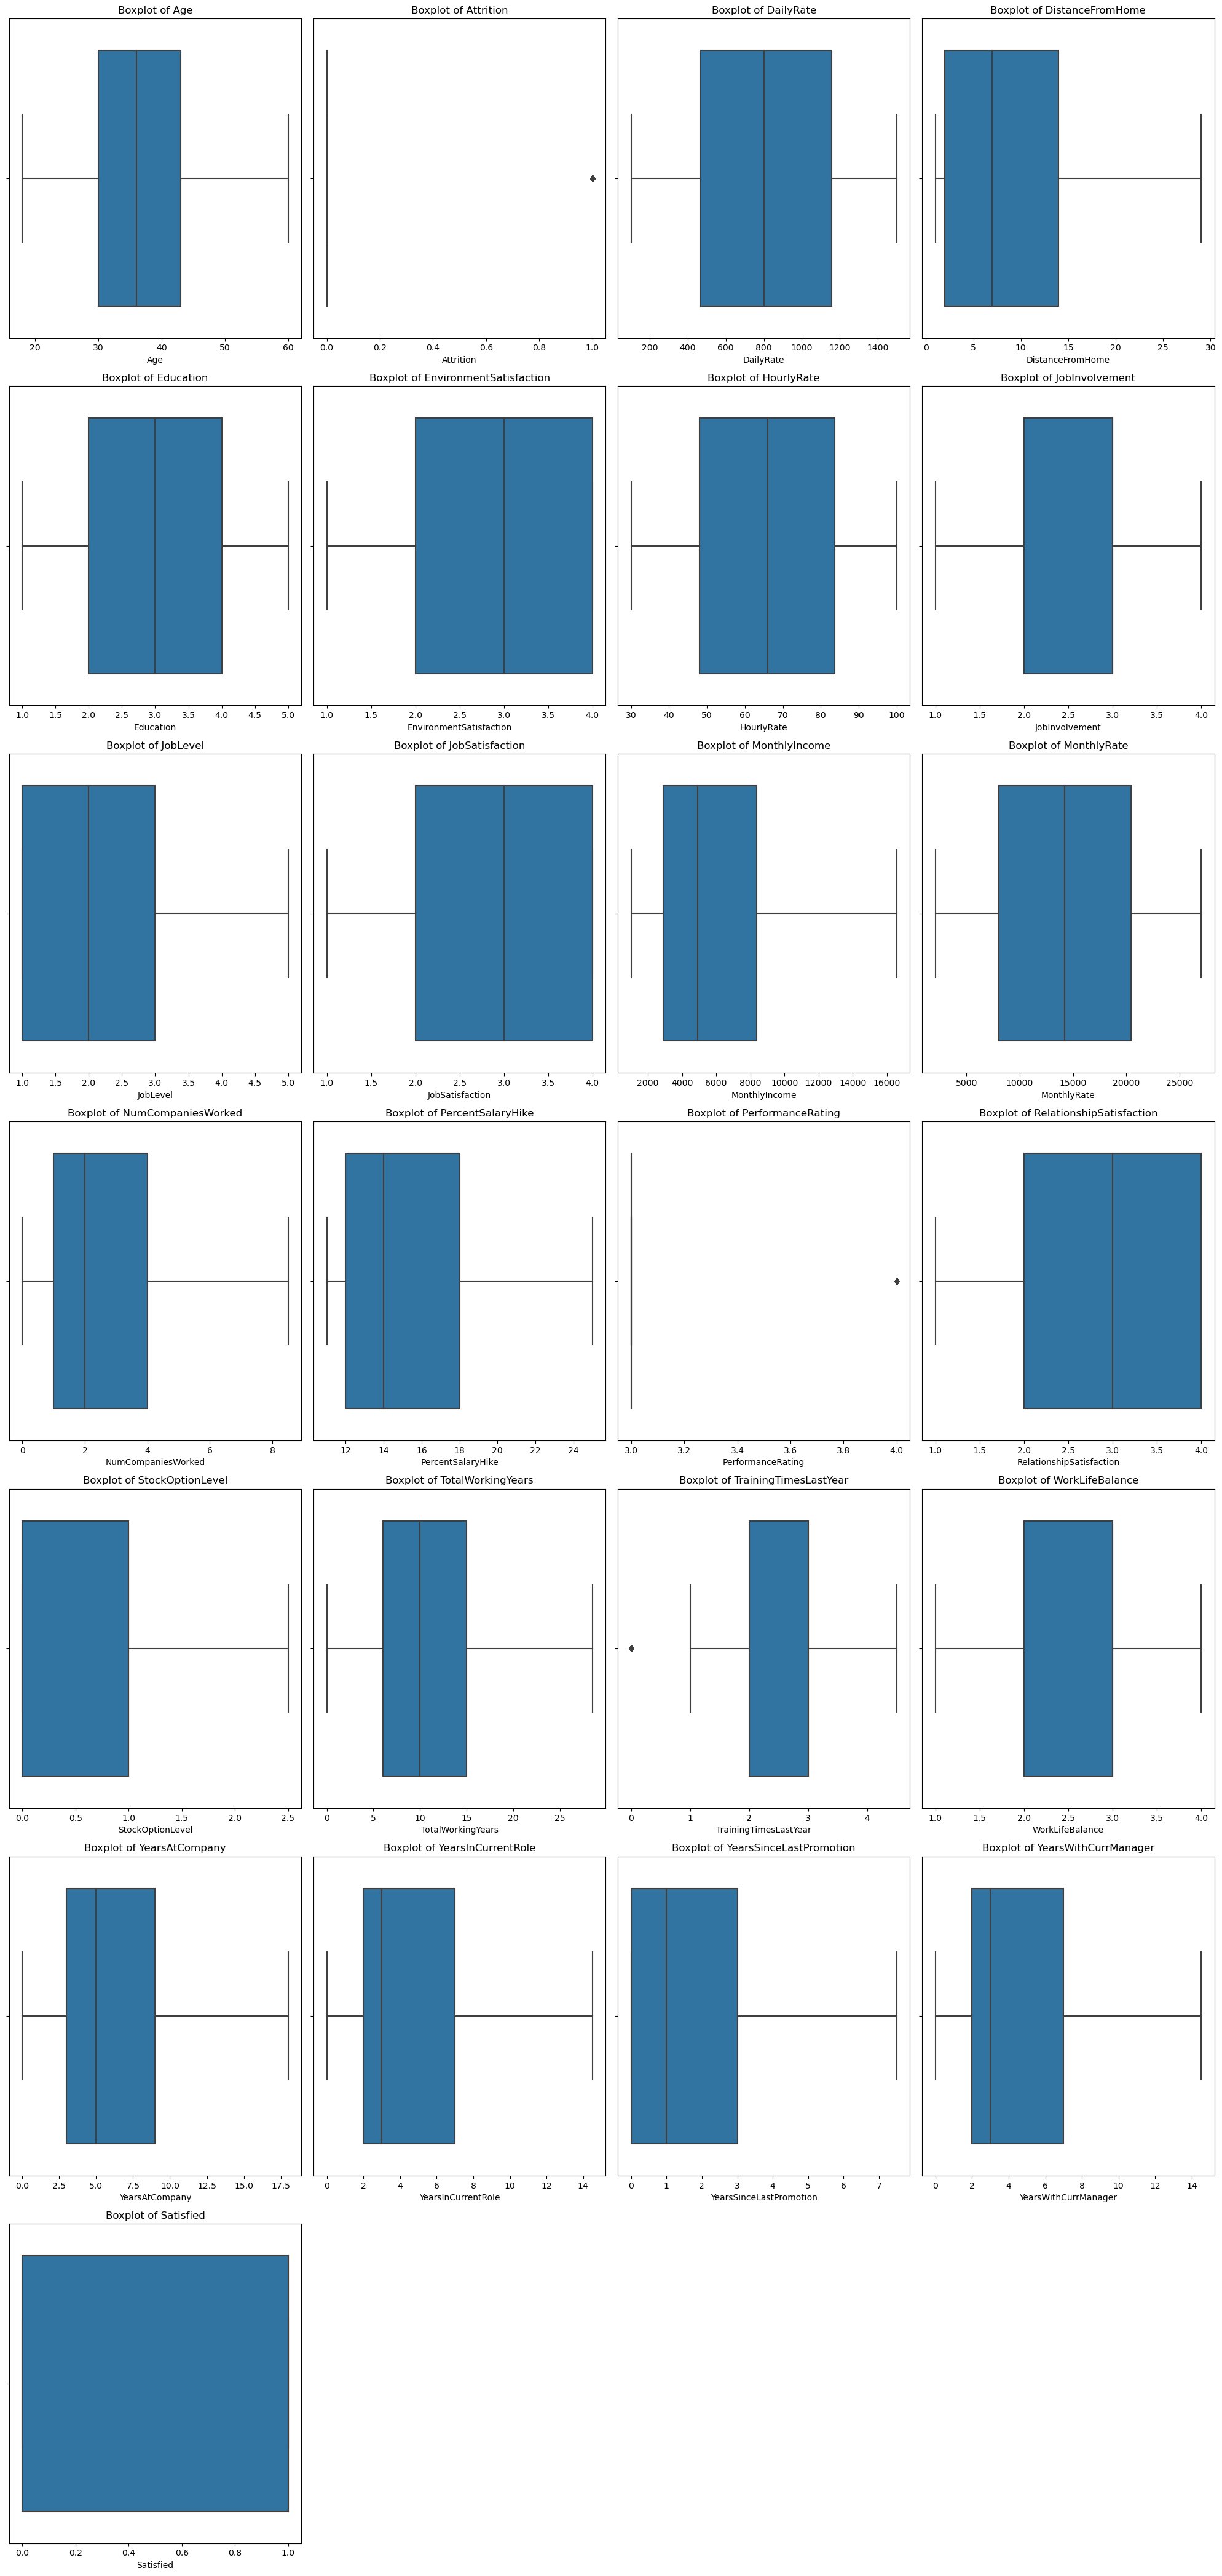

In [31]:
plot_numeric_variable_boxplots(df)

Most of the machine learning models cannot work with categorical data. Therefore, I will convert my categorical data into a format that the models can understand using one-hot encoding.

In [32]:
df_dum = pd.get_dummies(df, drop_first = True)
print(df_dum.shape)
df_dum.head()

(1470, 46)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41.0,1,1102.0,1.0,2.0,2.0,94.0,3.0,2.0,4.0,...,0,0,0,0,0,1,0,0,1,1
1,49.0,0,279.0,8.0,1.0,3.0,61.0,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,0,0
2,37.0,1,1373.0,2.0,2.0,4.0,92.0,2.0,1.0,3.0,...,1,0,0,0,0,0,0,0,1,1
3,33.0,0,1392.0,3.0,4.0,4.0,56.0,3.0,1.0,3.0,...,0,0,0,0,1,0,0,1,0,1
4,27.0,0,591.0,2.0,1.0,1.0,40.0,3.0,1.0,2.0,...,1,0,0,0,0,0,0,1,0,0


In machine learning, we split our data into two parts, training and test, to evaluate the performance of our model. First, we use the training data to develop our model and then we evaluate its performance on the test data. The test data is typically around 25% of the entire dataset, but due to the small size of my dataset, I will split it into a 15% test set and the remaining 85% will be used for training

In [33]:
train_set = df_dum.sample(frac = 0.90, random_state = 123)
test_set = df_dum.drop(train_set.index, axis = 0)
train_set.reset_index(drop = True, inplace = True)
test_set.reset_index(drop = True, inplace = True)
print(f"Train shape => {train_set.shape}\nTest shape => {test_set.shape}")

Train shape => (1323, 46)
Test shape => (147, 46)


Now we will not perform any operations on our test set. Let's develop a few simple models to see which model is more suitable for our data. Then, we will try to improve the performance of the selected model using various parameter optimization techniques. Let's get started.

In [34]:
X = train_set.drop('Attrition', axis = 1)
Y = train_set.Attrition

print(X.shape)

(1323, 45)


In [35]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X)

In [36]:
def mod (model):
    
    accuracy = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(accuracy_score))).mean()
    aps = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(average_precision_score))).mean()
    kappa =(cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(cohen_kappa_score))).mean()
    F1 = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(f1_score))).mean()
    ps = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(precision_score))).mean()
    recal = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(recall_score))).mean()
    auc = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(roc_auc_score))).mean()
    mcc = (cross_val_score(model, X_train_sc, Y, cv=5, scoring = make_scorer(matthews_corrcoef))).mean()
    
    return (accuracy, aps, kappa, F1, ps, recal, auc, mcc)

In [37]:
models = []
models.append(('LogRegression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('RandomForesst', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('Xgboost', XGBClassifier()))
models.append(('Lgbm', LGBMClassifier()))
models.append(('Catboost', CatBoostClassifier(verbose = 0)))

models

[('LogRegression', LogisticRegression()),
 ('KNN', KNeighborsClassifier()),
 ('LDA', LinearDiscriminantAnalysis()),
 ('RandomForesst', RandomForestClassifier()),
 ('GBC', GradientBoostingClassifier()),
 ('Xgboost',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, gamma=None,
                gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=None,
                reg_alpha=None, reg_lambda=None, ...)),
 ('Lgbm', LGBMClassi

In [38]:
model_name = []
model_metrics = []

for i in models:
    model_name.append(i[0])
    model_metrics.append(mod(i[1]))

In [39]:
final = pd.DataFrame(model_metrics, 
                      columns = ['Accuracy', 'APS', 'Kappa', 'F1', 'PS', 'Recal', 'Auc', 'Mcc'], 
                      index = model_name)
final.sort_values(by = 'Mcc', ascending = False)

,Accuracy,APS,Kappa,F1,PS,Recal,Auc,Mcc
LogRegression,0.874505,0.377978,0.443237,0.509396,0.689696,0.408084,0.686024,0.464946
LDA,0.873759,0.375450,0.443727,0.510787,0.680429,0.412957,0.687559,0.463464
Lgbm,0.871495,0.351731,0.396584,0.458633,0.715239,0.342525,0.657749,0.433222
Catboost,0.870743,0.329883,0.333344,0.382221,0.833562,0.253378,0.621283,0.409639
GBC,0.866201,0.330681,0.364497,0.426580,0.708576,0.309856,0.641415,0.403308
Xgboost,0.859400,0.312138,0.348770,0.417597,0.640119,0.319158,0.641111,0.379838
RandomForesst,0.860921,0.265648,0.178724,0.242007,0.930000,0.126578,0.571295,0.291774
KNN,0.853362,0.245040,0.204991,0.249716,0.712987,0.154485,0.570936,0.280801


In [40]:
X_val, y_val = test_set.drop("Attrition", axis = 1), test_set.Attrition
X_val_sc = sc.fit_transform(X_val)
X_val_sc

array([[ 0.13286962,  1.54643675, -0.83494378, ..., -0.99322026,
         1.60790729,  1.60790729],
       [-0.29173546,  1.59287625, -0.71827388, ...,  1.00682602,
        -0.6219264 ,  1.60790729],
       [ 0.23902088, -1.2814839 ,  1.61512413, ..., -0.99322026,
         1.60790729, -0.6219264 ],
       ...,
       [-1.03479434,  1.04293489, -0.48493407, ..., -0.99322026,
         1.60790729, -0.6219264 ],
       [-0.92864307, -1.43057912, -0.60160398, ...,  1.00682602,
        -0.6219264 ,  1.60790729],
       [-0.18558419, -0.27448018, -0.13492437, ...,  1.00682602,
        -0.6219264 , -0.6219264 ]])

One of the important problems in machine learning is choosing the right metric for evaluating model performance. Using accuracy as the evaluation metric in imbalanced datasets is a wrong approach. I don't know the best metric for imbalanced datasets, but I always prefer the MCC score. F1, AUC can also be used as metrics, but the MCC score is a great metric for binary classification tasks. The MCC score measures the correlation between the actual and predicted values. Therefore, the higher the correlation value, the better the prediction performance.

Based on the initial analysis, it seems that linear models perform better for this dataset. Logistic Regression and Linear Discriminant Analysis have the highest MCC scores. After optimizing the hyperparameters of these models as well as an LightGBM model, I will select the model with the highest MCC score for final model selection.

In [42]:
def fit_models(X_train, y_train, X_val, y_val):
    # Scale the data
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    
    # Fit and evaluate logistic regression model
    logistic_model = LogisticRegression().fit(X_train_sc, y_train)
    y_pred = logistic_model.predict(X_val_sc)
    logistic_mcc = (cohen_kappa_score(y_pred, y_val) + 1)/2
    
    # Fit and evaluate linear discriminant analysis model
    linear_model = LinearDiscriminantAnalysis().fit(X_train_sc, y_train)
    y_pred = linear_model.predict(X_val_sc)
    linear_mcc = (cohen_kappa_score(y_pred, y_val) + 1)/2
    
    # Fit and evaluate XGBoost model
    lgb_model = CatBoostClassifier(verbose = 0).fit(X_train_sc, y_train)
    y_pred = lgb_model.predict(X_val_sc)
    lgb_mcc = (cohen_kappa_score(y_pred, y_val) + 1)/2
    
    return {'Logistic Regression': logistic_mcc,
            'Linear Discriminant Analysis': linear_mcc,
            'LightGBM': lgb_mcc}


fit_models(X, Y, X_val, y_val)

{'Logistic Regression': 0.7905982905982907,
 'Linear Discriminant Analysis': 0.7507480550568522,
 'LightGBM': 0.7071713147410359}

The MCC score takes values in the range [-1, +1]. A value of 1 for Cohen's kappa score indicates perfect agreement between the predicted and actual values. However, the MCC score is usually used in a normalized form because the normalized MCC score takes values between 0 and 1, making it easier to interpret the strength of the score. In the above code, I showed how to normalize the Cohen's kappa scores by using the formula (score + 1) / 2. This transforms the scores to the range of 0 and 1, making them easier to interpret.

Now that we have decided on which models to use, let's train our models using advanced techniques. First, let's use Nested CV to see the scores of our data. Nested CV is a cross-validation method that is nested inside another cross-validation. And I can say it is my favorite cross-validation method. Let's get started.

**Nested CV**

****Logistic Regression****

In [43]:
X.reset_index(drop = True, inplace = True)
Y.reset_index(drop = True, inplace = True)

In [45]:

cv_outer = StratifiedKFold(n_splits=5, shuffle = True, random_state=0)
kappa_scores = []
tr_scores = []
models = []
fold = 0
for train_ix, test_ix in cv_outer.split(X_train_sc, Y):
        Xtrain, Xtest = X_train_sc[train_ix], X_train_sc[test_ix]
        ytrain, ytest = Y[train_ix], Y[test_ix]
        cv_inner = RepeatedStratifiedKFold(n_splits= 5, n_repeats=3)
        model = LogisticRegression()
        score = cross_val_score(model, Xtrain, ytrain, scoring = make_scorer(cohen_kappa_score), cv=cv_inner)
        tr_score = (np.mean(score) + 1)/2
        print(f'Fold: {fold + 1}')
        print("Train Normalize Cappa Score: ", tr_score)
        model.fit(Xtrain, ytrain)
        y_hat = model.predict(Xtest)
        kappa_score = (cohen_kappa_score(y_hat, ytest) + 1)/2
        print("Test Normalize Cappa Score: ", kappa_score)
        fold = fold +1
        kappa_scores.append(kappa_score)
        tr_scores.append(tr_score)
        models.append(model)
        
print('++++Result++++++++Result++++++++Result++++++++Result++++')
        
print(f'Average normalized MCC score for the train set => {np.mean(tr_score)}\nAverage normalized MCC score for the test set = > {np.mean(kappa_scores)}')

Fold: 1
Train Normalize Cappa Score:  0.7220042690699825
Test Normalize Cappa Score:  0.7495274102079394
Fold: 2
Train Normalize Cappa Score:  0.7103808721618209
Test Normalize Cappa Score:  0.771382795168844
Fold: 3
Train Normalize Cappa Score:  0.7202034599331684
Test Normalize Cappa Score:  0.7387231944786788
Fold: 4
Train Normalize Cappa Score:  0.7506303711078908
Test Normalize Cappa Score:  0.6597938144329897
Fold: 5
Train Normalize Cappa Score:  0.713787551948992
Test Normalize Cappa Score:  0.693165969316597
++++Result++++++++Result++++++++Result++++++++Result++++
Average normalized MCC score for the train set => 0.713787551948992
Average normalized MCC score for the test set = > 0.7225186367210098


Now, let's optimize our parameters using GridSearch and Nested CV and see how much we can improve our score.

In [46]:
outer_cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=0)
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

models = []
cv_score = []
fold = 0
for train_index, test_index in outer_cv.split(X_train_sc, Y):
    X_train, X_test = X_train_sc[train_index], X_train_sc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
        
    params = {'C': np.logspace(-4, 4, 20),
              'solver': ['lbfgs'],
              'penalty': ['l2']}
        
    model = LogisticRegression(max_iter=1000)
    grid_search = RandomizedSearchCV(model, param_distributions=params, 
                                     cv=inner_cv, error_score='raise', 
                               scoring=make_scorer(cohen_kappa_score))
    grid_result = grid_search.fit(X_train, y_train)
    best_params = grid_result.best_params_
    models.append(model.set_params(**best_params))
    y_pred = grid_search.predict(X_test)
    score = (cohen_kappa_score(y_pred, y_test) + 1) / 2
    cv_score.append(score)
    fold = fold + 1
    print(f'Fold {fold}: train score => {score}')
    
print(f'CV score = > {np.mean(cv_score)}')

Fold 1: train score => 0.7161310649023315
Fold 2: train score => 0.7603400458217774
Fold 3: train score => 0.7161310649023315
Fold 4: train score => 0.6597938144329897
Fold 5: train score => 0.7039337474120082
CV score = > 0.7112659474942877


Please pay close attention to this method. Using Nested CV means sacrificing a part of our training data, so I do not recommend using this method if your data size is not sufficient. We used a 5-fold cross-validation and obtained the highest score in the 5th fold. We saved the models generated during each fold. Therefore, we can take the parameters of the model that gave the highest score, or as another method, we can take the average of the predictions of each model and obtain a final prediction. I will demonstrate how that method is done in this kernel.According to studies, Halving Grid Search is 11 times faster than the normal GridSearch method. In addition, you can optimize your parameters using libraries such as Optuna and Hyperopt. I will demonstrate the use of Optuna for optimizing parameters for LightGbm in this kernel.

In [47]:
best_model_lr = LogisticRegression()
best_model_lr.set_params(**(models[1].get_params()))
best_model_lr

LogisticRegression(C=3792.690190732246, max_iter=1000)

In [48]:
best_model_lr.fit(X_train_sc, Y)
y_pred_log = best_model_lr.predict(X_val_sc)
print(f'Test Score = > {(cohen_kappa_score(y_pred_log, y_val) + 1)/2}')

Test Score = > 0.7905982905982907


Our test score did not improve. We can definitely increase this score by using more parameter combinations. Now let's perform the same operations for LinearDiscriminantAnalysis.

**NestedCV**

****Linear Discriminant Analysis****

In [51]:
cv_outer = StratifiedKFold(n_splits= 5)
kappa_scores = []
tr_scores = []
models = []
fold = 0
for train_ix, test_ix in cv_outer.split(X_train_sc, Y):
        Xtrain, Xtest = X_train_sc[train_ix], X_train_sc[test_ix]
        ytrain, ytest = Y[train_ix], Y[test_ix]
        cv_inner = StratifiedKFold(n_splits= 5)
        model = LinearDiscriminantAnalysis()
        score = cross_val_score(model, Xtrain, ytrain, 
                                scoring = make_scorer(cohen_kappa_score), cv=cv_inner)
        tr_score = (np.mean(score) + 1)/2
        print(f'Fold: {fold + 1}')
        print("Train Normalize Cappa Score: ", tr_score)
        model.fit(Xtrain, ytrain)
        y_hat = model.predict(Xtest)
        kappa_score = (cohen_kappa_score(y_hat, ytest) + 1)/2
        print("Test Normalize Cappa Score: ", kappa_score)
        fold = fold +1
        kappa_scores.append(kappa_score)
        tr_scores.append(tr_score)
        models.append(model)
        
print('++++Result++++++++Result++++++++Result++++++++Result++++')
        
print(f'Average normalized MCC score for the train set => {np.mean(tr_score)}\nAverage normalized MCC score for the train set = > {np.mean(kappa_scores)}')

Fold: 1
Train Normalize Cappa Score:  0.7162476736704168
Test Normalize Cappa Score:  0.7497639282341833
Fold: 2
Train Normalize Cappa Score:  0.7203855386652356
Test Normalize Cappa Score:  0.6955258177885915
Fold: 3
Train Normalize Cappa Score:  0.7094986898590003
Test Normalize Cappa Score:  0.7550529948237614
Fold: 4
Train Normalize Cappa Score:  0.722600857243465
Test Normalize Cappa Score:  0.7036181678214011
Fold: 5
Train Normalize Cappa Score:  0.7459432223267162
Test Normalize Cappa Score:  0.7053571428571428
++++Result++++++++Result++++++++Result++++++++Result++++
Average normalized MCC score for the train set => 0.7459432223267162
Average normalized MCC score for the train set = > 0.721863610305016


In [52]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_score = []
models = []
fold = 0

for train_index, test_index in outer_cv.split(X_train_sc, Y):
    X_train, X_test = X_train_sc[train_index], X_train_sc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    solvers = ['svd', 'lsqr', 'eigen']
    if model.get_params()['solver'] in ['lsqr', 'eigen']:
        shrinkage = np.random.uniform(low=0.0, high=1.0, size=(50,))
    else:
        shrinkage = [None]
    tol =  np.logspace(-6, -1, 10)
        
    params = {
        'solver': solvers,
        'shrinkage': shrinkage,
        'tol': tol
    }
    
    model = LinearDiscriminantAnalysis()
    grid_search = GridSearchCV(model, param_grid=params, cv=inner_cv, error_score='raise', 
                               scoring=make_scorer(cohen_kappa_score))
    grid_result = grid_search.fit(X_train, y_train)
    best_model = grid_result.best_estimator_
    models.append(best_model)
    y_pred = best_model.predict(X_test)
    score = (cohen_kappa_score(y_pred, y_test) + 1) / 2
    cv_score.append(score)
    fold += 1
    print(f'Fold {fold}: train score => {score}')
    
print(f'CV score = > {np.mean(cv_score)}')

Fold 1: train score => 0.7382257344974826
Fold 2: train score => 0.7549955263942738
Fold 3: train score => 0.7060635937885137
Fold 4: train score => 0.6734520780322307
Fold 5: train score => 0.71448087431694
CV score = > 0.717443561405888


In [53]:
model_preds = [model.predict(X_val_sc) for model in models]
y_pred = (np.mean(model_preds,axis=0)>=0.5).astype(int)
print(f'Test Score = > {(cohen_kappa_score(y_pred_log, y_val) + 1)/2}')

Test Score = > 0.7905982905982907


As you might have noticed, unlike the logistic regression model, here I used all the models built for prediction. And our test score improved. If our score did not improve, we could further adjust the search grid and optimize our parameters using libraries such as Optuna and Hyperopt. I will show how to do this for LightGBM.

**NestedCV**

****LightGBM****

In [55]:

outer_cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=0)
kappa_scores = []
tr_scores = []
models = []
fold = 0
for train_ix, test_ix in cv_outer.split(X_train_sc, Y):
        Xtrain, Xtest = X_train_sc[train_ix], X_train_sc[test_ix]
        ytrain, ytest = Y[train_ix], Y[test_ix]
        cv_inner = RepeatedStratifiedKFold(n_splits= 5, n_repeats=3)
        model =  LGBMClassifier()
        score = cross_val_score(model, Xtrain, ytrain, scoring = make_scorer(cohen_kappa_score),
                                cv=cv_inner)
        tr_score = (np.mean(score) + 1)/2
        print(f'Fold: {fold + 1}')
        print("Train Normalize Cappa Score: ", tr_score)
        model.fit(Xtrain, ytrain)
        y_hat = model.predict(Xtest)
        kappa_score = (cohen_kappa_score(y_hat, ytest) + 1)/2
        print("Test Normalize Cappa Score: ", kappa_score)
        fold = fold +1
        kappa_scores.append(kappa_score)
        tr_scores.append(tr_score)
        models.append(model)
        
print('++++Result++++++++Result++++++++Result++++++++Result++++')
        
print(f'Average normalized MCC score for the train set => {np.mean(tr_score)}\nAverage normalized MCC score for the test set = > {np.mean(kappa_scores)}')

Fold: 1
Train Normalize Cappa Score:  0.6519327303933193
Test Normalize Cappa Score:  0.749396726015783
Fold: 2
Train Normalize Cappa Score:  0.6737410926744375
Test Normalize Cappa Score:  0.6933515674310962
Fold: 3
Train Normalize Cappa Score:  0.6603263748414956
Test Normalize Cappa Score:  0.6875597476260277
Fold: 4
Train Normalize Cappa Score:  0.6639281249003182
Test Normalize Cappa Score:  0.6457789382071366
Fold: 5
Train Normalize Cappa Score:  0.6676961927360356
Test Normalize Cappa Score:  0.7153729071537291
++++Result++++++++Result++++++++Result++++++++Result++++
Average normalized MCC score for the train set => 0.6676961927360356
Average normalized MCC score for the test set = > 0.6982919772867545


I have written a function below that uses Nested CV and Optuna to optimize LightGBM parameters. However, since the function may take a long time to run, I am not running the function for now. That's all for now. If you have any questions or suggestions, please feel free to let me know in the comments.

In [ ]:
def objective(trial):
    
    param = {     
             "objective":"binary",
             'n_estimators':  trial.suggest_int('n_estimators',100,600,100),
             'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
             'reg_alpha':  trial.suggest_float('reg_lambda', 1e-3, 10.0),
             'num_leaves': trial.suggest_categorical('num_leaves', [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.1,0.2,0.5]),
             'max_bin': trial.suggest_categorical('max_bin', [100, 150, 500, 1000]),
             'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
             'scale_pos_weight': 90}
    
    #Implement nested cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    kappa_avgs = []
    for train_index, test_index in outer_cv.split(X, Y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        kappa_vals = []
        for inner_train_index, inner_test_index in inner_cv.split(X_train, y_train):
            inner_X_train, inner_X_test = X_train.iloc[inner_train_index,:], X_train.iloc[inner_test_index,:]
            inner_y_train, inner_y_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]
            model = LGBMClassifier(**param)
            model.fit(inner_X_train, inner_y_train)
            y_pred = model.predict(inner_X_test)
            kappa_score = (cohen_kappa_score(y_hat, ytest) + 1)/2
            kappa_vals.append(kappa_score)
        kappa_avg = np.mean(kappa_vals)
        kappa_avgs.append(kappa_avg)
    mean_kappa = np.mean(kappa_avgs)
    return mean_kappa*(-1)  

study = optuna.create_study(sampler = TPESampler())
study.optimize(objective, n_trials=250)
print("Best hyperparameters: ", study.best_params)